In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.8'

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

Using the convolutional base of the VGG16 network, trained on ImageNet, to extract features from cat and dog images, and then training a cat vs. dog classifier on top of these features.

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [11]:
conv_base.trainable = False

Now we start training our model, with the data augmentation:

In [13]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/fchollet/Downloads/Data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
74s - loss: 0.4465 - acc: 0.7810 - val_loss: 0.2056 - val_acc: 0.9120
Epoch 2/30
72s - loss: 0.2738 - acc: 0.8905 - val_loss: 0.1239 - val_acc: 0.9550
Epoch 3/30
72s - loss: 0.2088 - acc: 0.9145 - val_loss: 0.1194 - val_acc: 0.9560
Epoch 4/30
72s - loss: 0.1835 - acc: 0.9280 - val_loss: 0.1025 - val_acc: 0.9550
Epoch 5/30
72s - loss: 0.1642 - acc: 0.9330 - val_loss: 0.0903 - val_acc: 0.9680
Epoch 6/30
72s - loss: 0.1360 - acc: 0.9410 - val_loss: 0.0794 - val_acc: 0.9740
Epoch 7/30
72s - loss: 0.1426 - acc: 0.9465 - val_loss: 0.0968 - val_acc: 0.9560
Epoch 8/30
72s - loss: 0.1013 - acc: 0.9580 - val_loss: 0.1411 - val_acc: 0.9430
Epoch 9/30
72s - loss: 0.1177 - acc: 0.9500 - val_loss: 0.2105 - val_acc: 0.9310
Epoch 10/30
72s - loss: 0.0949 - acc: 0.9620 - val_loss: 0.0900 - val_acc: 0.9710
Epoch 11/30
72s - loss: 0.0915 - acc: 0.9655 - val_loss: 0.1204 - val_acc: 0.9630
Epoch 12/30
72s - loss:

In [14]:
model.save('cats_and_dogs_small_3.h5')

plot the results:

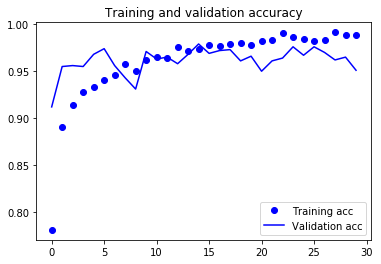

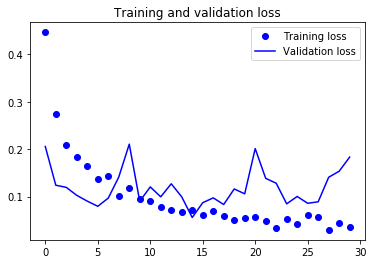

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As we can see, the performance reachs a validation accuracy of about 96%.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 32s - loss: 0.0215 - acc: 0.9935 - val_loss: 0.0980 - val_acc: 0.9720
Epoch 2/100
100/100 [==============================] - 32s - loss: 0.0131 - acc: 0.9960 - val_loss: 0.1247 - val_acc: 0.9700
Epoch 3/100
100/100 [==============================] - 32s - loss: 0.0140 - acc: 0.9940 - val_loss: 0.1044 - val_acc: 0.9790
Epoch 4/100
100/100 [==============================] - 33s - loss: 0.0102 - acc: 0.9965 - val_loss: 0.1259 - val_acc: 0.9770
Epoch 5/100
100/100 [==============================] - 33s - loss: 0.0137 - acc: 0.9945 - val_loss: 0.1036 - val_acc: 0.9800
Epoch 6/100
100/100 [==============================] - 33s - loss: 0.0183 - acc: 0.9935 - val_loss: 0.1260 - val_acc: 0.9750
Epoch 7/100
100/100 [==============================] - 33s - loss: 0.0141 - acc: 0.9945 - val_loss: 0.1575 - val_acc: 0.9690
Epoch 8/100
100/100 [==============================] - 33s - loss: 0.0094 - acc: 0.9965 - val_loss: 0.0935 - val_acc: 0.9780


100/100 [==============================] - 33s - loss: 0.0107 - acc: 0.9980 - val_loss: 0.1748 - val_acc: 0.9740
Epoch 67/100
100/100 [==============================] - 33s - loss: 5.1450e-04 - acc: 1.0000 - val_loss: 0.1922 - val_acc: 0.9710
Epoch 68/100
100/100 [==============================] - 33s - loss: 0.0054 - acc: 0.9985 - val_loss: 0.2299 - val_acc: 0.9680
Epoch 69/100
100/100 [==============================] - 33s - loss: 0.0091 - acc: 0.9965 - val_loss: 0.1533 - val_acc: 0.9730
Epoch 70/100
100/100 [==============================] - 33s - loss: 0.0190 - acc: 0.9965 - val_loss: 0.2232 - val_acc: 0.9690
Epoch 71/100
100/100 [==============================] - 33s - loss: 0.0058 - acc: 0.9985 - val_loss: 0.1773 - val_acc: 0.9710
Epoch 72/100
100/100 [==============================] - 33s - loss: 0.0072 - acc: 0.9990 - val_loss: 0.1660 - val_acc: 0.9760
Epoch 73/100
100/100 [==============================] - 33s - loss: 0.0036 - acc: 0.9990 - val_loss: 0.2354 - val_acc: 0.9700
E

In [20]:
model.save('cats_and_dogs_small_4.h5')

plot the result:

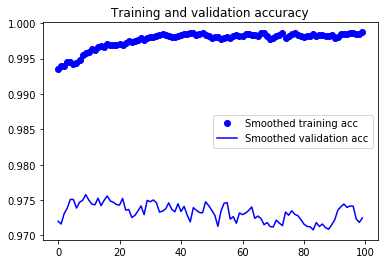

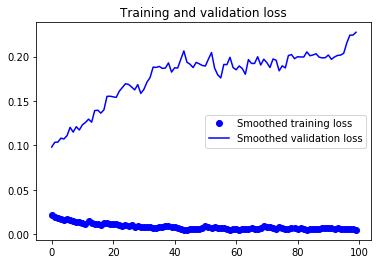

In [24]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


evaluate this model on the test data:

In [27]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.967999992371
